## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
import random
import os
import seaborn as sns
#import lal
from scipy.interpolate import interp1d
#sns.set(rc={'figure.figsize':(11.7,8.27)})
import sys
sys.path.insert(1, '..')

from scipy.stats import beta
from scipy.stats import lognorm
import h5py
import corner
import matplotlib.mlab as mlab

cp=sns.color_palette('Dark2', 20)
#sns.set_context('notebook')
#sns.set(style="white", palette="muted")
from scipy import stats
import get_wavelet_params as wp
from matplotlib import rc
from astropy import constants as const
from math import sqrt

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

## Helper functions

In [2]:
def GetPeakTime(time, data): 
    """ Grab the peak time of some data """
    t_peak = time[np.argmax(data)]
    return t_peak

def SubtractPeakTime(time, data): 
    """ Subtract the peak time of some data """
    t_peak = GetPeakTime(time, data)
    return time - t_peak

def EllString(ell):
    return str(ell).replace('.','p')

def GetBaseDir(ell, dist_mpc, mass):
    ell = EllString(ell)
    dist_mpc = str(dist_mpc)
    mass = str(mass)

    base_dir = "/home/maria.okounkova/BeyondGRAnalysis/Frames" \
             + "/dCS_" + ell + "/dCS_" + ell + "_mtotal_" + mass + "_dist_" + dist_mpc \
             + "/BW_dCS_" + ell + "_mtotal_" + mass + "_dist_" + dist_mpc + "_1e6/trigtime_1126259462.410700560_0.0_0.0_0/"  
    
    print(base_dir)

    return base_dir

def EllinKm(ell, mass):
    """ ell * mass * G / c^2 
        with 1000 to convert to km """
    val = ell * mass * const.M_sun * const.G /(const.c**2) / 1000
    print(val)
    return "%.1f km" % val.value 

## Compute overlaps

/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p0/dCS_0p0_mtotal_68_dist_400/BW_dCS_0p0_mtotal_68_dist_400/trigtime_1126259462.410700560_0.0_0.0_0/
[0.001494397364503408]
0.0 m
/home/maria.okounkova/BeyondGRAnalysis/Frames/dCS_0p1/dCS_0

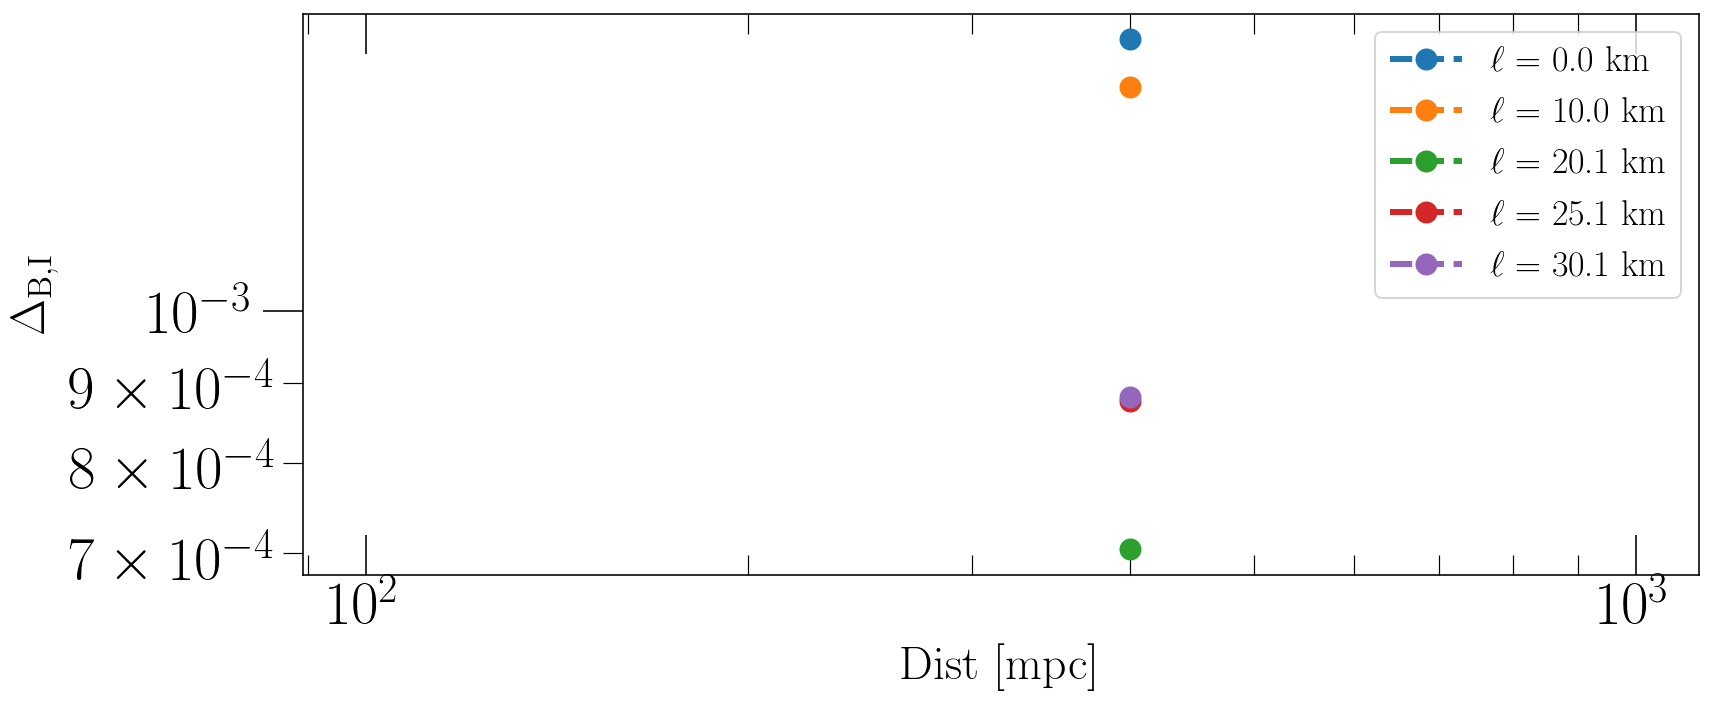

In [61]:

def InnerProduct(freq, hA, hB, PSD):

    """ Compute the inner product using the conventions of 
    https://arxiv.org/abs/2003.09456 Eq. 8"""
    
    ## Spacing in frequency
    df = freq[1] - freq[0]
    
    ## Terms inside the integral
    product = hA * np.conj(hB) / PSD 
    
    ## Compute the integral 
    total = 4.0 * np.real(np.sum(product)) * df
    return total
    
def Overlap(ell, dist_mpc, mass):
    
    """ Compute the overlap between the injected 
        waveform and the BW waveform for a given dCS
        coupling constant and SNR. Uses the conventions 
        of https://arxiv.org/abs/2003.09456 """
    
    ## compute the network inner products
    
    total_bw_inj = 0.0
    total_bw_bw = 0.0
    total_inj_inj = 0.0
    
    ## Compute the inner products summer over detectors.
    ## See Eq. 7 of https://arxiv.org/abs/2003.09456
    for detector in ["L1", "H1"]:
        
        ## Grab the psd, bw, and injected data for this detector
        freq, psd = GetPSD(ell, dist_mpc, mass, detector)
        freq, bw, d2, d3, d4, d5 = GetBWFrequencyDomainWaveform(ell, dist_mpc, mass, detector)
        freq, inj = GetInjectedFrequencyDomainWaveform(ell, dist_mpc, mass, detector)
        
        total_bw_inj = total_bw_inj + InnerProduct(freq, bw, inj, psd)
        total_bw_bw = total_bw_bw + InnerProduct(freq, bw, bw, psd)
        total_inj_inj = total_inj_inj + InnerProduct(freq, inj, inj, psd)
        
    #print(total_bw_inj, total_bw_bw, total_inj_inj)
    
    ## Eq. 6 in https://arxiv.org/abs/2003.09456
    overlap = total_bw_inj / np.sqrt(total_bw_bw  * total_inj_inj)
    return overlap
    

plt.figure(figsize=(12, 5))

ells = [0.0, 0.1, 0.2, 0.25, 0.3]
#colors = ['blue', '#148c8a', '#45ba7e']
dist_arr = [400]
mass = 68

for ell in ells:
    
    ## compute the overlap for the median waveform
    deltas = [1.0 - Overlap(ell, dist, mass) for dist in dist_arr]
    print(deltas)
    plt.plot(dist_arr, deltas, '--o', label=r'$\ell$ = ' + EllinKm(ell, mass), markersize=10)
    
## Add in 1/SNR^2 curve 
#snrs = np.linspace(SNRs[0], SNRs[-1], 100)
#snr_curve = snrs**-2.0
#plt.plot(snrs, snr_curve*100, color='black')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('$\Delta_\mathrm{B,I}$')
plt.xlabel('Dist [mpc]')
plt.tight_layout()
plt.savefig('Deltas.pdf')

plt.show()
    

# LALInference Analysis

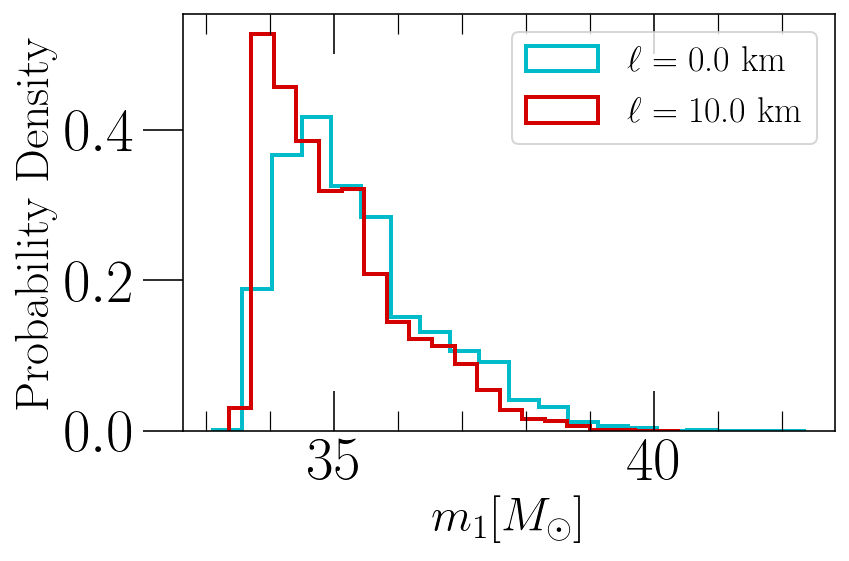

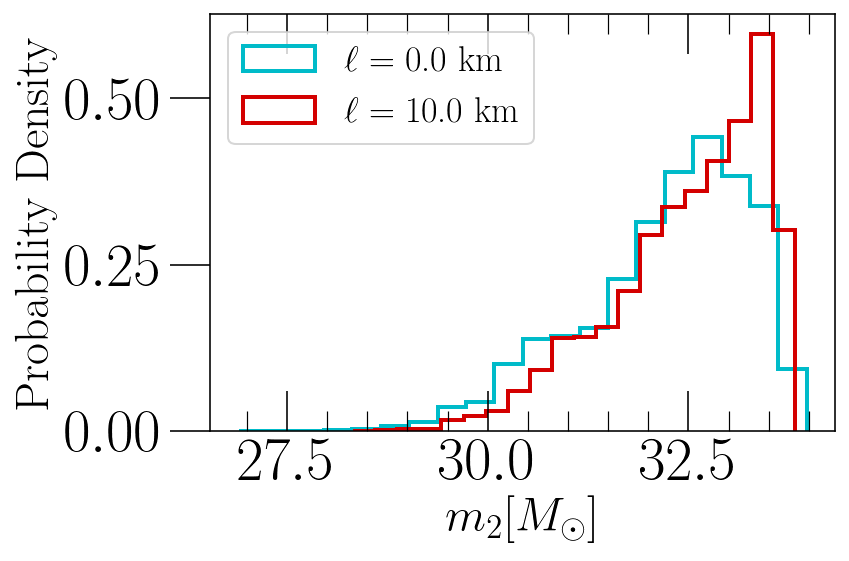

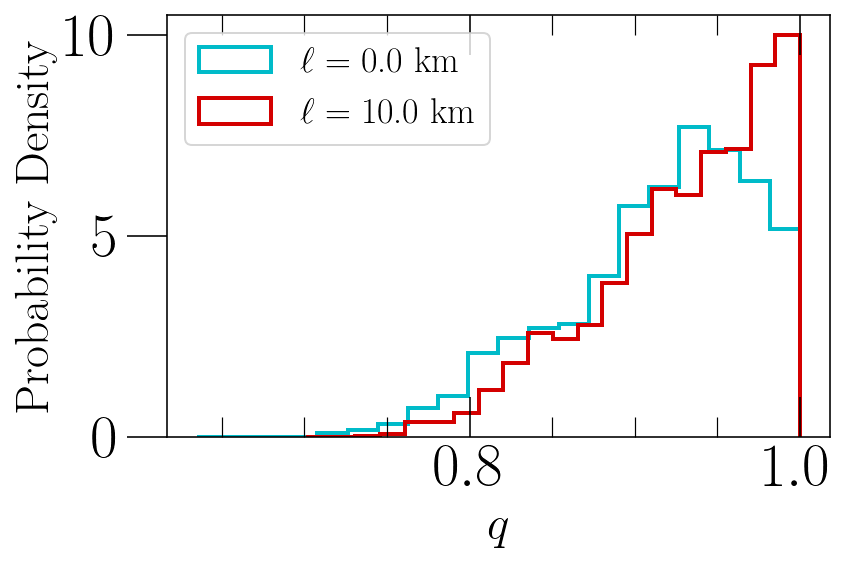

In [19]:
TruthDict = {'m1' : 37.386085075316785, 'm2' : 30.613915574190038, 'mc' : 29.42222678574253, 'mtotal' : 68.0, 'q' : 1.0/1.2212121309577342, \
             'chi_eff' : 0.0, 'a1' : 0.329894028067, 'a2' : 0.439941681413, 'af_nonevol' : 0.692}
LabelDict = {'m1' : r"$m_1 [M_\odot]$", 'm2' : r"$m_2 [M_\odot] $", 'mc' : r"$\mathcal{M} [M_\odot]$", 'mtotal' : r"$M [M_\odot]$", 'q' : r"$q$", \
             'chi_eff' : r"$\chi_\mathrm{eff}$", 'a1' : r"$a_1$", 'a2' : r"$a_2$", 'af_nonevol' : r"$a_f$"}


def FindPosteriorIndex(string):
        f = '/home/maria.okounkova/public_html/dCS_0p0_SNR_100/LAL/posterior_samples.dat'
        with open(f) as file:
            labels = file.readline().split()
            #print(labels)
        return labels.index(string)
    
def ReadPosteriorData(string, ell):
    index = FindPosteriorIndex(string)
    f = '/home/maria.okounkova/public_html/dCS_' + EllString(ell) + '_SNR_100/LAL/posterior_samples.dat'
    data = np.loadtxt(f, comments="#",usecols=([index]),unpack=True, skiprows=1)
    return data

def Posteriors(quantity):

    def histogram(ell, color):
        data = ReadPosteriorData(quantity, ell)
        nbins = 20
        H = plt.hist(data, color=color, alpha=1.0, linewidth=2.0, histtype=u'step', density=True, bins = nbins, label=r'$\ell = $ ' + EllinKm(ell))
        H = plt.hist(data, color=color, alpha=0.0, density=True, bins = nbins)
        
    plt.figure(figsize=(6,4))
    histogram(0.0, "#00bbc9")
    histogram(0.1, "#D40000")
    plt.legend(loc='best', ncol=1, fontsize=18)
    plt.ylabel('Probability Density')
    plt.xlabel(LabelDict[quantity])
    plt.tight_layout()
    plt.savefig('Hist_' + quantity + '.pdf')
    plt.show()
    
    
#Posteriors(20, 'Mass Ratio', 'MassRatio', 0.8188585542593252)
Posteriors('m1')
Posteriors('m2')
Posteriors('q')

['h1_cplx_snr_amp', 'h1_cplx_snr_arg', 'h1_optimal_snr', 'l1_cplx_snr_amp', 'l1_cplx_snr_arg', 'l1_optimal_snr', 'azimuth', 'deltalogl', 'deltaloglh1', 'deltalogll1', 'logl', 'logprior', 'logw', 'matched_filter_snr', 'optimal_snr', 'phase', 'phi12', 'phi_jl', 'q', 't0', 'time', 'ra', 'dec', 'dist', 'psi', 'mc', 'a1', 'a2', 'tilt1', 'tilt2', 'lal_amporder', 'lal_approximant', 'lal_pnorder', 'sky_frame', 'f_ref', 'flow', 'psdscaleflag', 'signalmodelflag', 'alpha', 'theta_jn', 'm1', 'm2', 'eta', 'mtotal', 'h1l1_relative_phase', 'h1_end_time', 'l1_end_time', 'v1_end_time', 'h1l1_delay', 'h1v1_delay', 'l1h1_delay', 'l1v1_delay', 'v1h1_delay', 'v1l1_delay', 'a1z', 'a2z', 'chi_eff', 'chi_tot', 'chi_p', 'redshift', 'm1_source', 'm2_source', 'mtotal_source', 'mc_source', 'iota', 'theta1', 'phi1', 'theta2', 'phi2', 'beta', 'af_nonevol', 'afz_nonevol', 'mf_nonevol', 'l_peak_nonevol', 'mf_source_nonevol', 'e_rad_nonevol', 'cosiota', 'costilt1', 'costilt2', 'costheta_jn', 'cosbeta']
['h1_cplx_snr_a

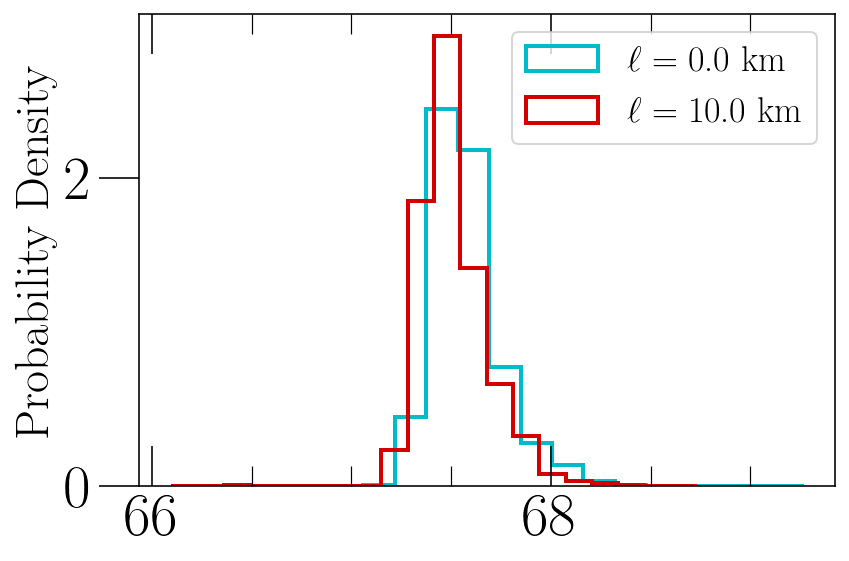

In [13]:
Posteriors('mtotal')

In [ ]:
def GetDataForMassCorner(ell, quants):
    labels = [LabelDict[q] for q in quants]
    truths = [TruthDict[q] for q in quants]
    vals = np.vstack([ReadPosteriorData(q, ell) for q in quants]).transpose()
    return vals, labels, truths
    

In [ ]:
def CornerPlot(quantities, figname):
    data_0p0, labels, truths = GetDataForMassCorner(0.0, quantities)
    data_0p1, labels, truths = GetDataForMassCorner(0.1, quantities)
    
    cs = sns.color_palette('husl', n_colors=2)
    
    dim = len(labels)
    ranges = [1.0 for d in labels]

    fig = corner.corner(data_0p0, labels=labels,
                       title_kwargs={"fontsize": 20}, label_kwargs={"fontsize": 20}, color=cs[0], 
                       show_titles=False)
    corner.corner(data_0p1, fig=fig, range = ranges, color=cs[1],
                 #truths = truths, truth_color = '#cccacb'
                 )
    
    ax_arr = fig.get_axes()
    
    ## scatter the truths
    for cc in range(1, dim):
        for rr in range(cc):
            ax_arr[cc*dim + rr].scatter([truths[rr]], [truths[cc]], color = 'black', s=200, marker='*')
            
    for rr in range(dim):
        ax_arr[rr*dim + rr].axvline(truths[rr], ls='--', lw=1.0, color='black')
    
    ## add in the legend
    x = [0.0, 0.0]
    y = [0.0, 0.0]
    l1 = ax_arr[0].plot(x, y, label=EllinKm(0.0), color = cs[0])
    l2 = ax_arr[0].plot(x, y, label=EllinKm(0.1), color = cs[1])
    legend = ax_arr[1].legend(handles=[l1[0], l2[0]], title = '$\ell$', frameon=False)
    plt.setp(legend.get_title(),fontsize=20)

    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
    plt.tight_layout()
    plt.savefig(figname + '.pdf')
    plt.show()

In [ ]:
CornerPlot(['chi_eff', 'a1', 'a2', 'af_nonevol'], 'SpinCorner')

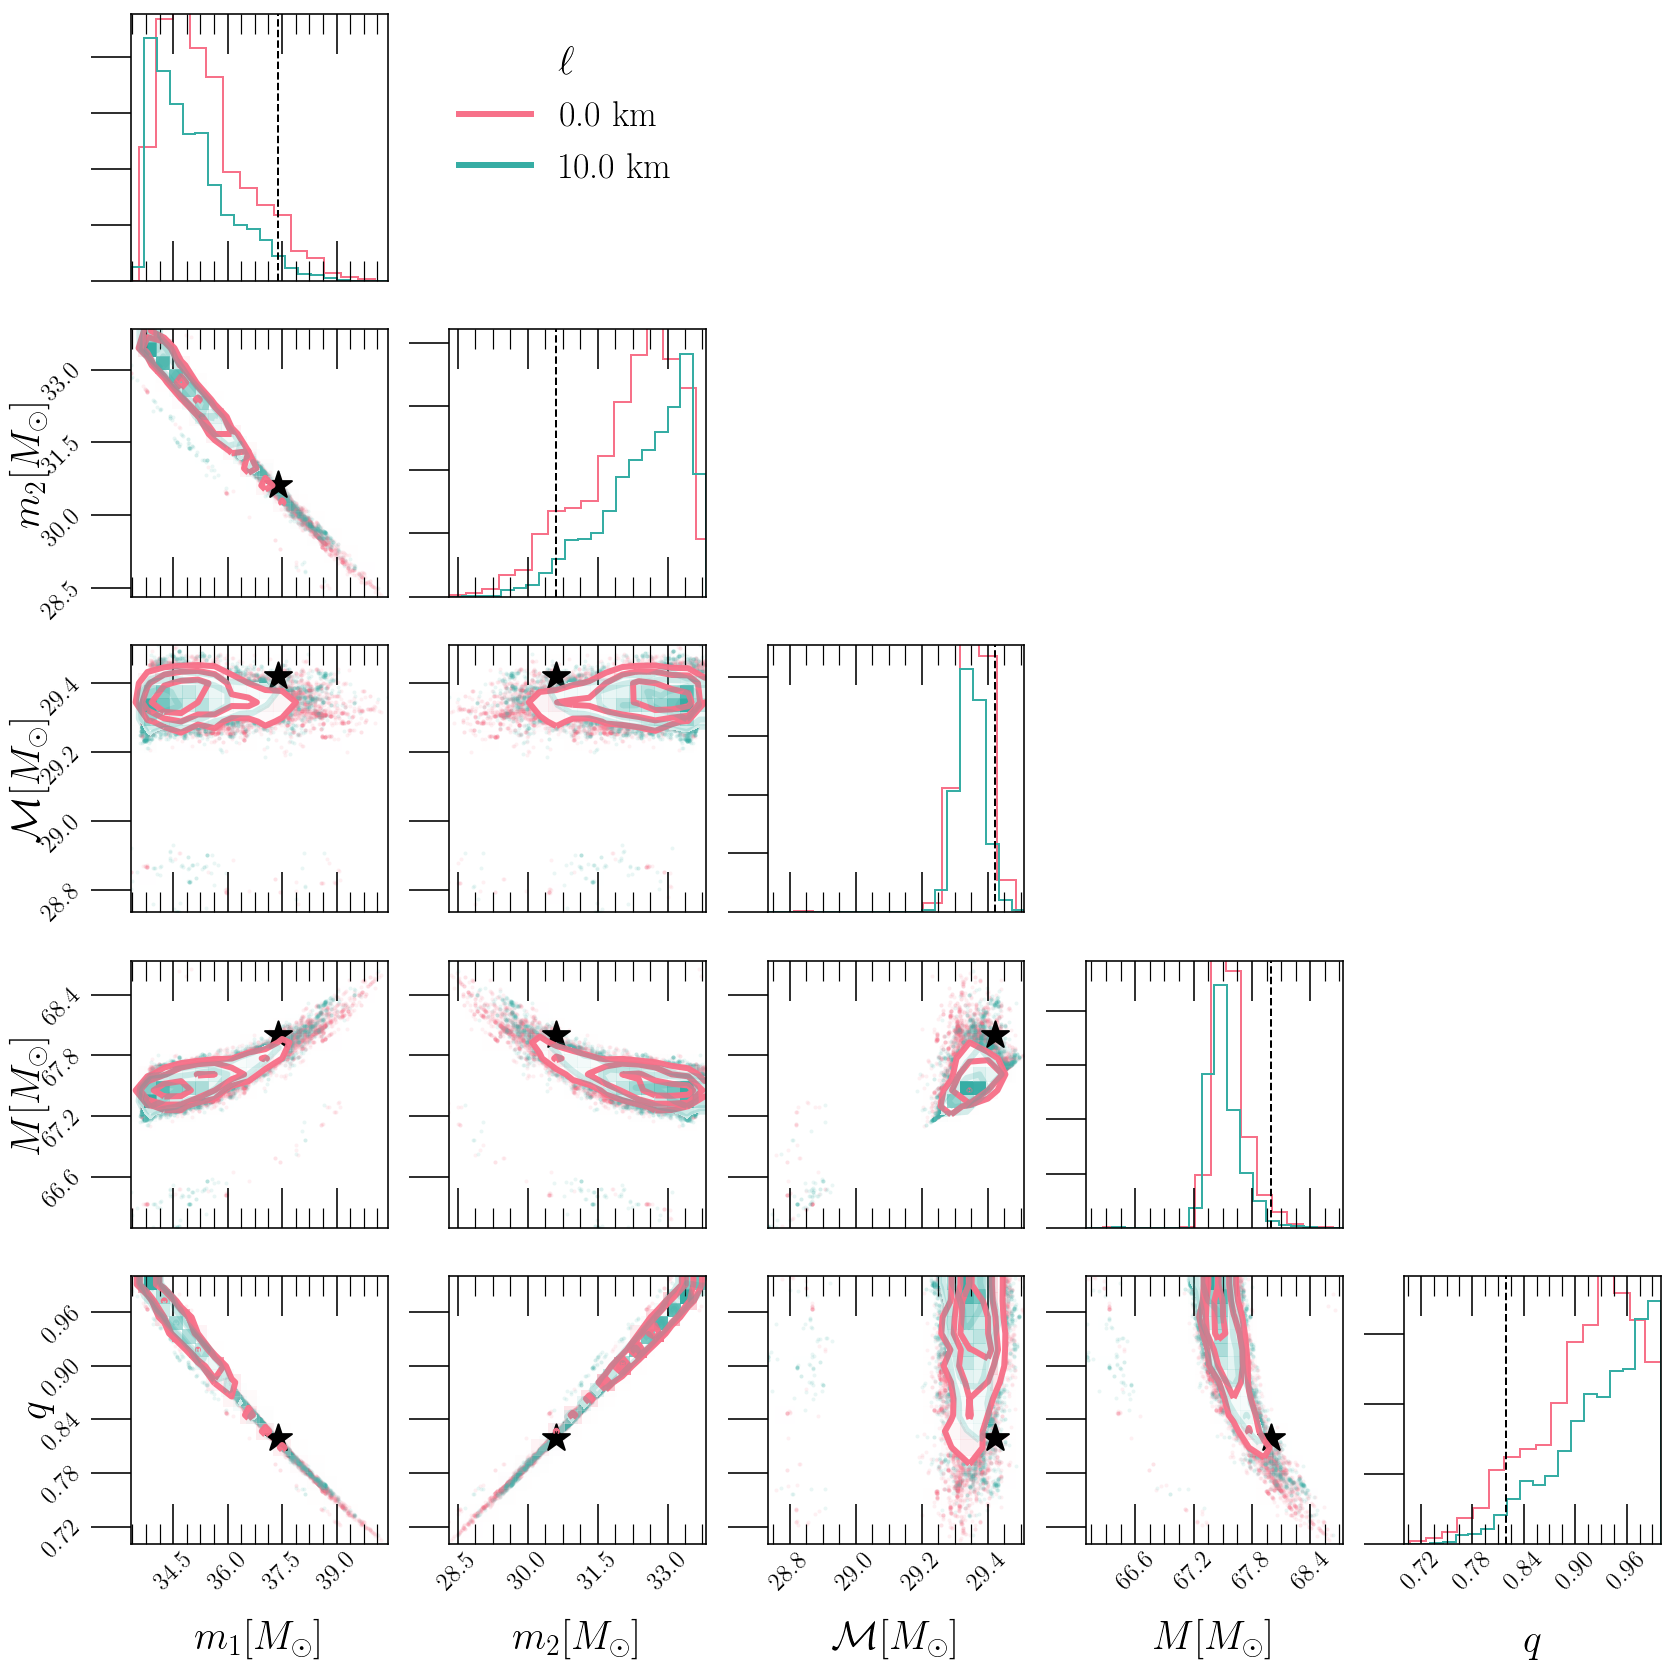

In [228]:
CornerPlot(['m1', 'm2', 'mc', 'mtotal', 'q'], 'MassCorner')

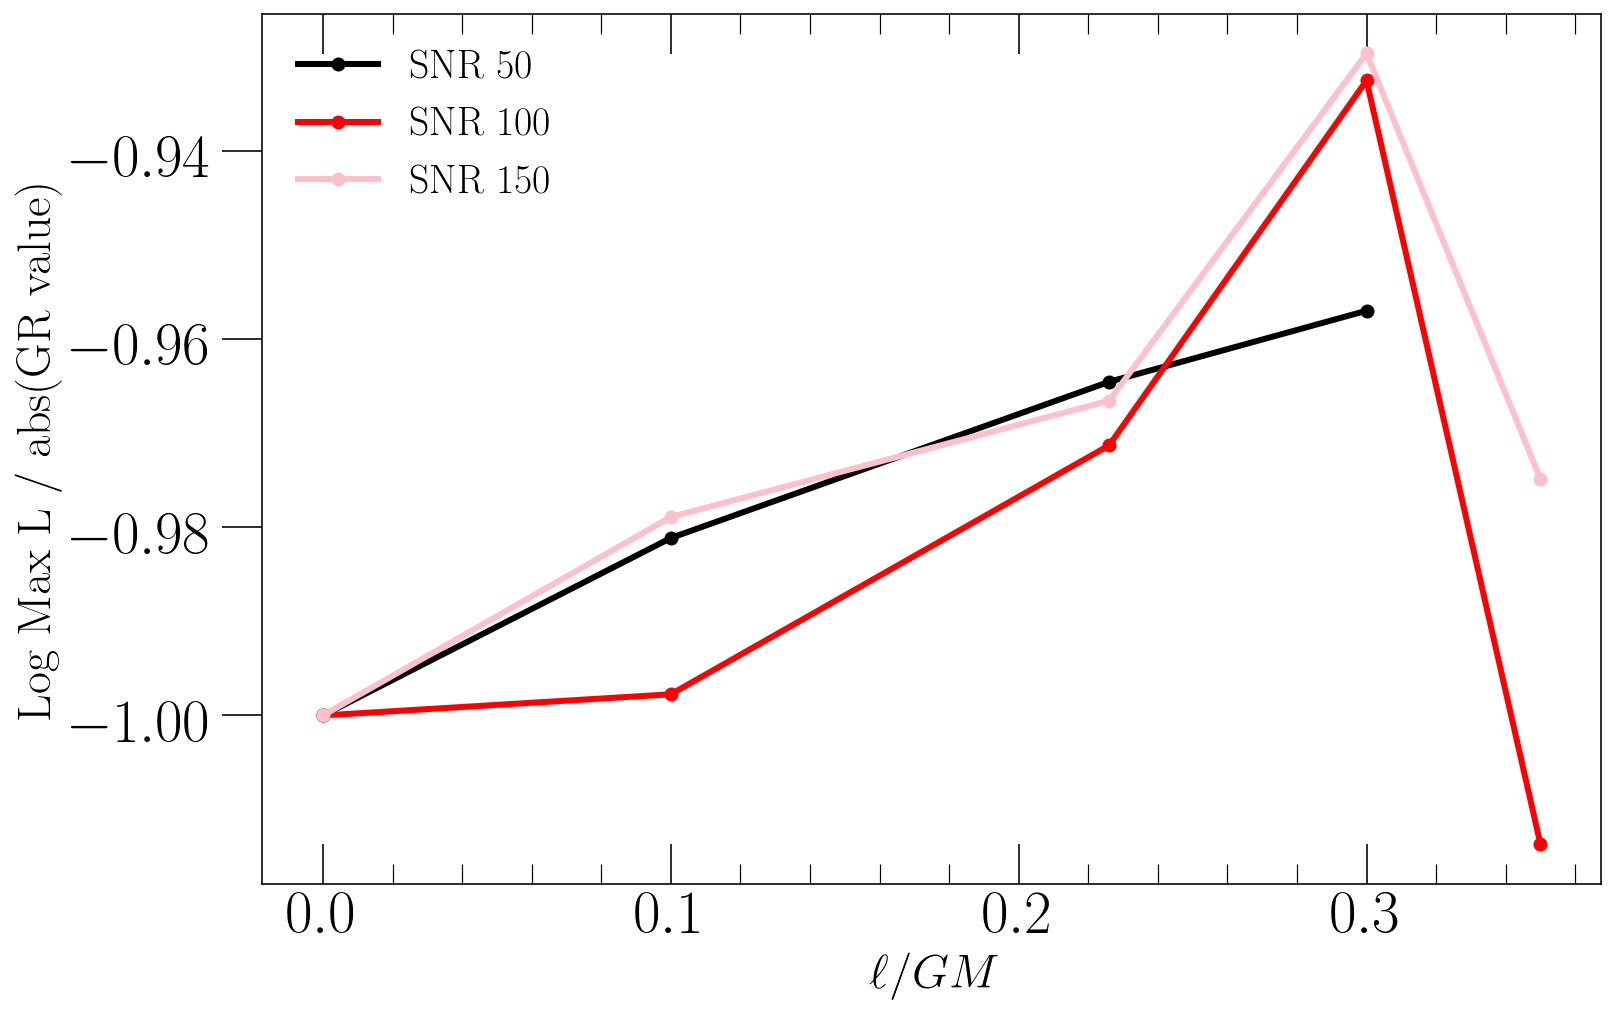

In [22]:
def PlotLalResults():
    
    fig = plt.figure(figsize=(12, 8))
    
    def Plotting(color):
        data = log_max_L
        data = np.divide(data, abs(data[0]))
        plt.plot(ells, data, '-o', label = 'SNR ' + str(SNR), color=color)
        
    SNR = 50
    ells = [0.0, 0.1, 0.226, 0.3]
    infos = [33.33943053766527, 33.27902130128047, 33.46795382239394, 36.368500842784776]
    log_bayes = [1103.3622992143576, 1103.649807193546, 1106.1890765506655, 1117.464690178644]
    log_evidence = [-59.9279890071096, -59.7058779172422, -60.17635768015842, -63.18271070245623]
    log_max_L = [-20.99027619655584, -20.59435630504892, -20.2458326619907, -20.087265401995637]
    
    Plotting('black')
    
    SNR = 100
    ells = [0.0, 0.1, 0.226, 0.3, 0.35]
    infos = [41.77785440165114, 41.508061217779236, 43.19584613981526, 45.59749064081437, 50.80037694108096]
    log_bayes = [4523.434917677935, 4524.085179101318, 4537.765239323135, 4593.8262256499165, 4685.89732918412]
    log_evidence = [-129.7265199037327, -129.3375613418361, -127.69621470012132, -128.76337787448537, -140.8218678227305]
    log_max_L = [-80.22932257589162, -80.04879239608742, -77.92588005483536, -74.81403700335235, -81.32654411141769]
    
    Plotting('red')
    
    SNR = 150
    ells = [0.0, 0.1, 0.226, 0.3, 0.35]
    infos = [49.32489406216867, 51.29391029046961, 50.80874164054725, 54.15444417137049, 61.58649050843306]
    log_bayes = [10234.23658487197, 10234.228216543279, 10264.792814529867, 10397.074520777824, 10616.349927944671]
    log_evidence = [-235.37600912125518, -235.97358993511938, -232.4954570224399, -228.75270359445577, -243.76883961651603]
    log_max_L = [-179.22051454375259, -175.43979597908762, -173.22367769115021, -166.6082007460601, -174.71542878407175]
    
    Plotting('pink')
    
    
    plt.xlabel(r'$\ell/GM$')
    plt.ylabel('Log Max L / abs(GR value)')
    plt.legend(frameon=False, fontsize=20)
    plt.show()
    
PlotLalResults()